In [36]:
import random
import torch
import torch_geometric
from torch_geometric import utils
from torch_geometric.nn import SAGEConv, MessagePassing
from torch_geometric.typing import Adj, OptPairTensor, Size
from torch_sparse import SparseTensor, matmul
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np

from typing import Union, Tuple

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [39]:
# ec_hic = np.load('data/GBM39ec_5k_collapsed_matrix.npy')
# hsr_hic = np.load('data/GBM39HSR_5k_collapsed_matrix.npy')

ec_hic = np.load('data/ec_adj_mat.npy')
hsr_hic = np.load('data/hsr_adj_mat.npy')

In [40]:
ec_df = pd.read_csv('data/ec_cleaned.csv')
hsr_df = pd.read_csv('data/hsr_cleaned.csv')

In [41]:
hsr_feats = torch.tensor(hsr_df[['read_count', 'total_genes']].to_numpy())
hsr_labels = torch.zeros(hsr_feats.shape[0])

ec_feats = torch.tensor(ec_df[['read_count', 'total_genes']].to_numpy())
ec_labels = torch.ones(ec_feats.shape[0])

In [42]:
def hic_to_sparse(hic_mat):
    #adj_mat = np.triu(hic_mat)
    sparse_adj = coo_matrix(hic_mat)

    return utils.from_scipy_sparse_matrix(sparse_adj)

In [43]:
hsr_edge_index, hsr_edge_attr = hic_to_sparse(hsr_hic)
hsr_graph = torch_geometric.data.Data(edge_index = hsr_edge_index, edge_attr = hsr_edge_attr, x = hsr_feats, y = hsr_labels)

ec_edge_index, ec_edge_attr = hic_to_sparse(ec_hic)
ec_graph = torch_geometric.data.Data(edge_index = ec_edge_index, edge_attr = ec_edge_attr, x = ec_feats, y = ec_labels)

In [44]:
x = torch.cat([ec_feats, hsr_feats], dim=0)
hsr_edge_index = hsr_edge_index + ec_labels.shape[0]
edge_index = torch.cat([ec_edge_index, hsr_edge_index], dim=1)
edge_attr = torch.cat([ec_edge_attr, hsr_edge_attr], dim=0)
edge_index, edge_attr = utils.to_undirected(edge_index, edge_attr)
labels = torch.cat([ec_labels, hsr_labels], dim=0)

G = torch_geometric.data.Data(edge_index = edge_index, edge_attr = edge_attr, x = x, y = labels)

In [45]:
class SAGEConvCat(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        aggr: str = "mean",
        normalize: bool = False,
        root_weight: bool = True,
        project: bool = False,
        bias: bool = True,
        **kwargs,
    ):
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight
        self.project = project

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        super().__init__(aggr, **kwargs)

        aggr_out_channels = in_channels[0]

        self.lin_l = nn.Linear(aggr_out_channels, out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = nn.Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_l.reset_parameters()
        
        if self.root_weight:
            self.lin_r.reset_parameters()

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj, edge_attr: Tensor, size: Size = None) -> Tensor:
        if isinstance(x, Tensor):
            x = (x, x)

        if self.project and hasattr(self, 'lin'):
            x = (self.lin(x[0]).relu(), x[1])

        edge_attr = torch.log1p(edge_attr.float())

        out = self.propagate(edge_index, x=x, size=size, edge_attr=edge_attr)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out = out + self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out

    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        return x_j #* edge_attr.view(-1, 1)

    def message_and_aggregate(self, adj_t: Adj, x: OptPairTensor) -> Tensor:
        if isinstance(adj_t, SparseTensor):
            adj_t = adj_t.set_value(None, layout=None)
            
        return spmm(adj_t, x[0], reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, aggr={self.aggr})')
    


In [46]:
class GraphSAGE(nn.Module):
    def __init__(self, num_feat, graph_conv_layer_sizes, lin_hidden_sizes, num_classes):
        super().__init__()
        self.embeds = None

        self.conv1 = SAGEConvCat(graph_conv_layer_sizes[0], graph_conv_layer_sizes[1])
        #self.conv2 = SAGEConvCat(graph_conv_layer_sizes[1], graph_conv_layer_sizes[2])
        #self.conv3 = SAGEConvCat(graph_conv_layer_sizes[2], graph_conv_layer_sizes[3])
        
        self.lin1 = nn.Linear(lin_hidden_sizes[0], lin_hidden_sizes[1])
        #self.lin2 = nn.Linear(lin_hidden_sizes[1], lin_hidden_sizes[2])
        #self.lin3 = nn.Linear(lin_hidden_sizes[2], lin_hidden_sizes[3])
            
        self.loss_calc = nn.CrossEntropyLoss()
        self.torch_softmax = nn.Softmax(dim=1)

        self.reset_parameters()

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.conv1(x, edge_index, edge_attr)
        h = torch.relu(h)
        #h = self.conv2(h, edge_index, edge_attr)
        #h = torch.relu(h)
        #h = self.conv3(h, edge_index, edge_attr)
        #h = torch.relu(h)

        self.embeds = h
            
        scores = h
        scores = self.lin1(scores)
        # scores = torch.relu(scores)
        # scores = self.lin2(scores)
        # scores = torch.relu(scores)
        # scores = self.lin3(scores)
        
        return scores

    def loss(self, scores, labels):
        xent_loss = self.loss_calc(scores, labels)
        return xent_loss

    def calc_softmax_pred(self, scores):
        softmax = self.torch_softmax(scores)
        predicted = torch.argmax(softmax, 1)
        return softmax, predicted

    def get_embeds(self):
        if self.embeds is not None:
            return self.embeds

        print("Untrained Model: Please train model first")
        return None

    def reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.fill_(0)
    

In [47]:
def split_data(G, train_ratio=0.8, test_ratio=0.2):
    assert train_ratio + test_ratio == 1, "Ratios must sum to 1."
    
    num_nodes = G.x.shape[0]  # Total number of nodes
    indices = torch.randperm(num_nodes)  # Shuffle node indices randomly
    
    # Compute split size
    train_size = int(train_ratio * num_nodes)
    
    # Assign indices to train and test sets
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    # Create boolean masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    test_mask[test_idx] = True

    # Attach masks to the graph
    G.train_mask = train_mask
    G.test_mask = test_mask

    return G

In [48]:
def train(model, optimizer, graph, device):
    model.train()
    optimizer.zero_grad()
    scores = model(graph)
    loss = model.loss(scores[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss.item(), scores

def test(model, graph, device):
    model.eval()
    scores = model(graph)
    softmax, predicted = model.calc_softmax_pred(scores)
    accs = []
    for mask in [graph.train_mask, graph.test_mask]:
        correct = (predicted[mask] == graph.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    
    return tuple(accs)

In [51]:
num_features = G.num_node_features
num_classes = 2
graph_sage_layer_sizes = [num_features,8]
linear_layer_sizes = [8, num_classes]

# Hyperparameters
learning_rate = 0.001
weight_decay = 5e-4
num_epochs = 1500
#dropout_value = 0.5

# Initialize the model, optimizer, and send to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(num_features, graph_sage_layer_sizes, linear_layer_sizes, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.5)
#model.dropout_value = dropout_value

# Assign train and test masks to graph
G.x = G.x.float()
G.y = G.y.long()
G = split_data(G)
G = G.to(device)

In [52]:
train_accs = []
test_accs = []

# Training loop - Entire graph in one model
for epoch in range(1, num_epochs + 1):
    loss, _ = train(model, optimizer, G, device)
    train_acc, test_acc = test(model, G, device)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    if epoch % 100 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 100, Loss: 1500.7577, Train Acc: 0.4838, Test Acc: 0.5644
Epoch 200, Loss: 115.6699, Train Acc: 0.4988, Test Acc: 0.3762
Epoch 300, Loss: 32.7164, Train Acc: 0.4963, Test Acc: 0.3861
Epoch 400, Loss: 3.1818, Train Acc: 0.5037, Test Acc: 0.5545
Epoch 500, Loss: 2.7714, Train Acc: 0.5237, Test Acc: 0.5842
Epoch 600, Loss: 2.9900, Train Acc: 0.5287, Test Acc: 0.4059
Epoch 700, Loss: 2.3165, Train Acc: 0.5237, Test Acc: 0.4356
Epoch 800, Loss: 1.8013, Train Acc: 0.5561, Test Acc: 0.5743
Epoch 900, Loss: 1.2245, Train Acc: 0.5112, Test Acc: 0.4356
Epoch 1000, Loss: 2.8950, Train Acc: 0.5187, Test Acc: 0.4059
Epoch 1100, Loss: 0.9993, Train Acc: 0.5436, Test Acc: 0.5644
Epoch 1200, Loss: 1.6176, Train Acc: 0.5162, Test Acc: 0.6139
Epoch 1300, Loss: 1.5703, Train Acc: 0.5187, Test Acc: 0.4356
Epoch 1400, Loss: 1.6609, Train Acc: 0.5262, Test Acc: 0.4059
Epoch 1500, Loss: 0.9278, Train Acc: 0.5162, Test Acc: 0.6139


In [32]:
from sklearn.decomposition import PCA

embeds = model.get_embeds().detach().cpu()
pca = PCA(n_components=2)
pca_embeds = pca.fit_transform(embeds)
pca_embeds.shape

(502, 2)

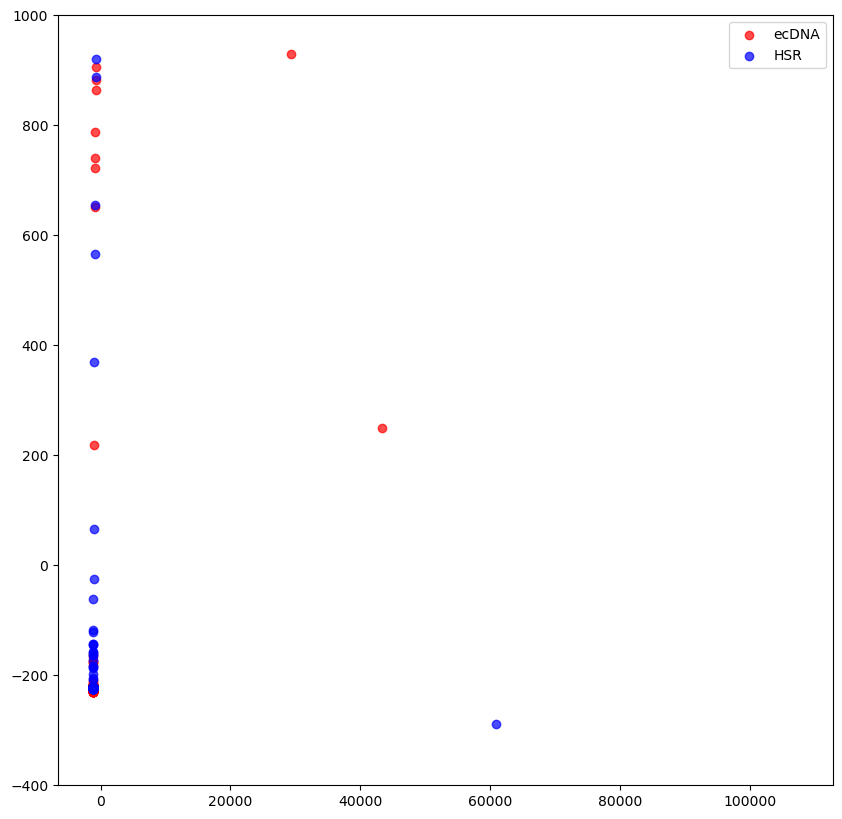

In [33]:
ec_mask = (G.y == 1).cpu()

plt.figure(figsize=(10,10))
plt.scatter(pca_embeds[:, 0][ec_mask], pca_embeds[:, 1][ec_mask], color='red', label='ecDNA', alpha=0.7)
plt.scatter(pca_embeds[:, 0][~ec_mask], pca_embeds[:, 1][~ec_mask], color='blue', label='HSR', alpha=0.7)
plt.ylim(-400, 1000)
plt.legend()
plt.show()

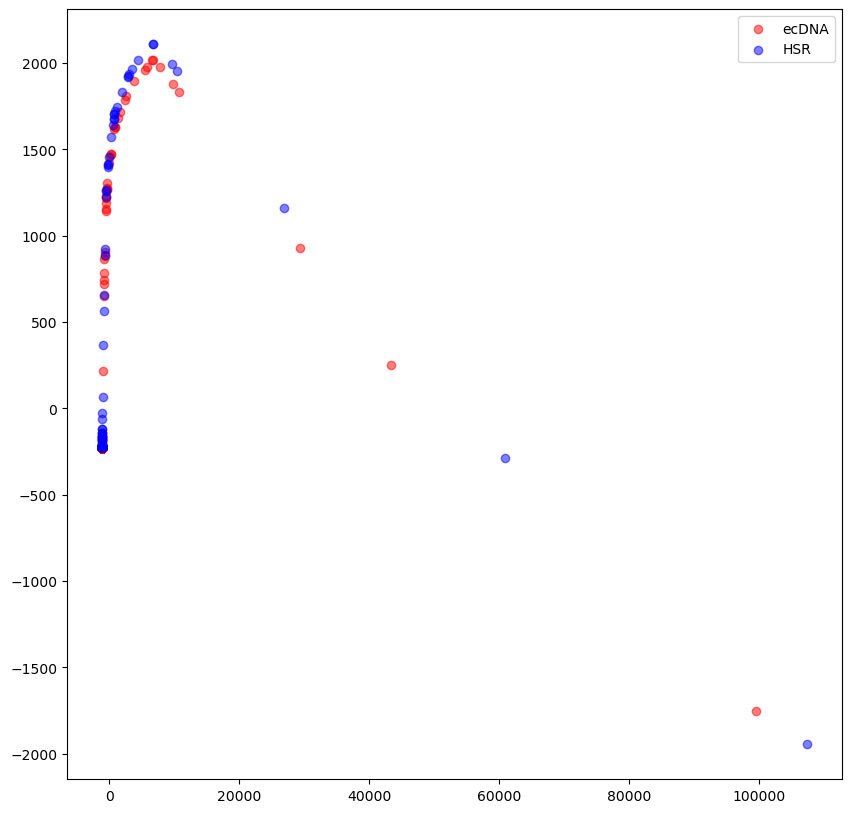

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(pca_embeds[:, 0][ec_mask], pca_embeds[:, 1][ec_mask], color='red', label='ecDNA', alpha=0.5)
plt.scatter(pca_embeds[:, 0][~ec_mask], pca_embeds[:, 1][~ec_mask], color='blue', label='HSR', alpha=0.5)
plt.legend()
plt.show()